In [1]:
# System tools
import scipy.misc
import random
import time
import sys
import os
import numpy as np

# Pytorch
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import torch.nn.functional as F

# Image I/O
import PIL
from  matplotlib import pyplot as plt

# Analysis
from sklearn.metrics import confusion_matrix
import pandas as pd

%matplotlib inline

# Image I/O
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

In [2]:
def check_and_create_folder(directory):
    try:
        os.stat(directory)
        print ('folder: ', directory, 'exits, do you want to remove it')
    except:
        os.mkdir(directory)
        print ('create ', directory)

# UNet train

### Hyper parameters

In [3]:
INPUT_IMG_SIZE = (480, 640)             # HEIGHT, WIDTH
BATCH_SIZE   = 3
NUM_EPOCHS   = 1000
NUM_WROKERS  = 0
LR           = 1e-4
MOMENTUM     = 0
WEIGHT_DECAY = 1e-5
STEP_SIZE    = 50
GAMMA        = 0.5
DATASET_ROOT = "./person_dataset_folder"
MODELS_ROOT  = "./pereson_models"
CLASSES = ["background", "person"]    # classes with 'background' element
BACKBONE = "resnet34"
#BACKBONE = "resnet18"
#BACKBONE = "mobilenet_v2"

MASKS_DIR    = os.path.join(DATASET_ROOT, "masks")
LABELS_DIR   = os.path.join(DATASET_ROOT, "labels")
IMAGES_DIR   = os.path.join(DATASET_ROOT, "images")
if not os.path.isdir(MODELS_ROOT):
    os.mkdir(MODELS_ROOT)
NUM_CLASSES = len(CLASSES)

In [4]:
data_list = pd.read_csv(os.path.join(DATASET_ROOT, "train.csv"), header=None)
data_list

,0,1
0,images/frame0016.jpg,masks/frame0016.png
1,images/frame0000.jpg,masks/frame0000.png
2,images/frame0097.jpg,masks/frame0097.png
3,images/frame0085.jpg,masks/frame0085.png
4,images/frame0017.jpg,masks/frame0017.png
...,...,...
75,images/frame0067.jpg,masks/frame0067.png
76,images/frame0011.jpg,masks/frame0011.png
77,images/frame0015.jpg,masks/frame0015.png
78,images/frame0071.jpg,masks/frame0071.png


In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataset_csv_file, phase):
        
        self.data_list = pd.read_csv(dataset_csv_file)
        
        print("********** Dataset Info start **********\n")
        print("Source: " + dataset_csv_file)
        print("Classes: {}".format(CLASSES))
        print("Amount of data: {}".format(len(self.data_list)))
        print("\n*********** Dataset Info end ***********\n")
        
        self.data_transform = transforms.Compose([
                                transforms.ToPILImage(), \
                                transforms.Resize(INPUT_IMG_SIZE), \
                                transforms.ToTensor(), \
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                                ])
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        image_path   = self.data_list.iloc[index, 0]
        mask_path    = self.data_list.iloc[index, 1]
        
        # Read image
        # image_raw = self.default_loader(os.path.join(DATASET_ROOT, image_path))
        image_raw = cv2.imread(os.path.join(DATASET_ROOT, image_path))
        input_image = self.data_transform(image_raw)
        # Read mask
        # mask_raw = PIL_Image.open(mask_path).convert('LA')
        mask_raw = cv2.imread(os.path.join(DATASET_ROOT, mask_path), cv2.IMREAD_GRAYSCALE)
        mask_raw = cv2.resize(mask_raw, (INPUT_IMG_SIZE[1], INPUT_IMG_SIZE[0]))
        mask_each_classes = torch.zeros(NUM_CLASSES, INPUT_IMG_SIZE[0], INPUT_IMG_SIZE[1])
        for i in range(NUM_CLASSES):
            mask_each_classes[i][mask_raw == i] = 1
        batch = {'input': input_image, 'target': mask_each_classes, 'mask_raw':mask_raw, 'image_raw': image_raw}
        # batch = {'input': input_image, 'target': mask_each_classes}
        return batch
    
    def pil_loader(self, path):
        with open(path, "rb") as f:
            with PIL.Image.open(f) as img:
                return img.convert("RGB")

    def accimage_loader(self, path):
        try:
            return accimage.Image(path)
        except IOError:
            # Potentially a decoding problem, fall back to PIL.Image
            return pil_loader(path)

    def default_loader(self, path):
        if torchvision.get_image_backend() == "accimage":
            return self.accimage_loader(path)
        else:
            return self.pil_loader(path)

In [6]:
# Training data loader
train_csv_path   = os.path.join(DATASET_ROOT, "train.csv")
train_dataset    = CustomDataset(dataset_csv_file=train_csv_path, phase="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WROKERS)

# Validation data loader
val_csv_path   = os.path.join(DATASET_ROOT, "val.csv")
val_dataset    = CustomDataset(dataset_csv_file=val_csv_path, phase='val')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WROKERS)

# Testing data loader
test_csv_path   = os.path.join(DATASET_ROOT, "test.csv")
test_dataset    = CustomDataset(dataset_csv_file=test_csv_path, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0)

********** Dataset Info start **********

Source: ./person_dataset_folder/train.csv
Classes: ['background', 'person']
Amount of data: 79

*********** Dataset Info end ***********

********** Dataset Info start **********

Source: ./person_dataset_folder/val.csv
Classes: ['background', 'person']
Amount of data: 9

*********** Dataset Info end ***********

********** Dataset Info start **********

Source: ./person_dataset_folder/test.csv
Classes: ['background', 'person']
Amount of data: 10

*********** Dataset Info end ***********



In [7]:
# Load model
model = smp.Unet(BACKBONE, classes=NUM_CLASSES, activation='softmax', encoder_weights='imagenet')
model.cuda()

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA) 

In [8]:
def train(model, optimizer, scheduler, loss_list, model_name):
    for epoch in range(NUM_EPOCHS):
        model.train()
        configs    = "resnetunet_{}_batch{}_epoch{}_RMSprop_lr{}".format(model_name, BATCH_SIZE, epoch, LR)
        model_path = os.path.join(MODELS_ROOT, configs)
        accuracy = 0
        count = 0
        
        for index, batch in enumerate(train_dataloader):
            optimizer.zero_grad()

            if torch.cuda.is_available():
                inputs = batch['input'].cuda()
                targets = batch['target'].cuda()
            else:
                inputs, targets = batch['X'], batch['Y']

            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            
            if index % 13 == 0:
                print('Index: {}\tInput_len: {}\tTrain_dataloader_len: {}'.format(index, len(inputs), len(train_dataloader)))
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, index * len(inputs), len(train_dataloader.dataset), 100. * index / len(train_dataloader), loss.item()))
                #print("epoch{}, iter{}, loss: {}".format(epoch, index, loss))
                #loss_plot.append(loss / (len(train_dataset)))
#                 print(loss)
  
        scheduler.step()
        loss_list.append(loss)
        print("==== Finish epoch {} ====".format(epoch))
        if epoch % 100 == 0:
            torch.save(model.state_dict(), model_path + '.pkl')
#         val(epoch)

In [9]:
loss_list = []
train(model, optimizer, scheduler, loss_list, model_name=BACKBONE)

/home/iscilab/.local/lib/python3.6/site-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 0 [0/79 (0%)]	Loss: 0.718383
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 0 [39/79 (48%)]	Loss: 0.573628
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 0 [26/79 (96%)]	Loss: 0.557225
==== Finish epoch 0 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 1 [0/79 (0%)]	Loss: 0.549330
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 1 [39/79 (48%)]	Loss: 0.534467
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 1 [26/79 (96%)]	Loss: 0.533886
==== Finish epoch 1 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 2 [0/79 (0%)]	Loss: 0.532625
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 2 [39/79 (48%)]	Loss: 0.525840
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 2 [26/79 (96%)]	Loss: 0.524880
==== Finish epoch 2 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 3 [0/79 (0%)]	Loss: 0.521209
Index: 13	Input_l

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 27 [39/79 (48%)]	Loss: 0.505325
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 27 [26/79 (96%)]	Loss: 0.504781
==== Finish epoch 27 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 28 [0/79 (0%)]	Loss: 0.505254
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 28 [39/79 (48%)]	Loss: 0.504911
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 28 [26/79 (96%)]	Loss: 0.505298
==== Finish epoch 28 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 29 [0/79 (0%)]	Loss: 0.504989
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 29 [39/79 (48%)]	Loss: 0.504905
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 29 [26/79 (96%)]	Loss: 0.504823
==== Finish epoch 29 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 30 [0/79 (0%)]	Loss: 0.504594
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 30 [39/79 (48%)]	Loss: 0.504539
I

Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 54 [26/79 (96%)]	Loss: 0.504138
==== Finish epoch 54 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 55 [0/79 (0%)]	Loss: 0.504156
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 55 [39/79 (48%)]	Loss: 0.503917
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 55 [26/79 (96%)]	Loss: 0.503814
==== Finish epoch 55 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 56 [0/79 (0%)]	Loss: 0.504132
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 56 [39/79 (48%)]	Loss: 0.503834
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 56 [26/79 (96%)]	Loss: 0.504093
==== Finish epoch 56 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 57 [0/79 (0%)]	Loss: 0.504141
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 57 [39/79 (48%)]	Loss: 0.503888
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 57 [26/79 (96%)]	Loss: 0.503820
=

Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 82 [0/79 (0%)]	Loss: 0.503736
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 82 [39/79 (48%)]	Loss: 0.503681
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 82 [26/79 (96%)]	Loss: 0.503792
==== Finish epoch 82 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 83 [0/79 (0%)]	Loss: 0.504076
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 83 [39/79 (48%)]	Loss: 0.503742
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 83 [26/79 (96%)]	Loss: 0.503727
==== Finish epoch 83 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 84 [0/79 (0%)]	Loss: 0.503769
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 84 [39/79 (48%)]	Loss: 0.503747
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 84 [26/79 (96%)]	Loss: 0.503877
==== Finish epoch 84 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 85 [0/79 (0%)]	Loss: 0.503763
Inde

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 109 [39/79 (48%)]	Loss: 0.503541
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 109 [26/79 (96%)]	Loss: 0.503553
==== Finish epoch 109 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 110 [0/79 (0%)]	Loss: 0.503512
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 110 [39/79 (48%)]	Loss: 0.503692
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 110 [26/79 (96%)]	Loss: 0.503486
==== Finish epoch 110 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 111 [0/79 (0%)]	Loss: 0.503536
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 111 [39/79 (48%)]	Loss: 0.503643
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 111 [26/79 (96%)]	Loss: 0.503446
==== Finish epoch 111 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 112 [0/79 (0%)]	Loss: 0.503567
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 112 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 136 [39/79 (48%)]	Loss: 0.503496
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 136 [26/79 (96%)]	Loss: 0.503489
==== Finish epoch 136 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 137 [0/79 (0%)]	Loss: 0.503646
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 137 [39/79 (48%)]	Loss: 0.503408
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 137 [26/79 (96%)]	Loss: 0.503625
==== Finish epoch 137 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 138 [0/79 (0%)]	Loss: 0.503992
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 138 [39/79 (48%)]	Loss: 0.503397
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 138 [26/79 (96%)]	Loss: 0.503406
==== Finish epoch 138 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 139 [0/79 (0%)]	Loss: 0.503487
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 139 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 163 [39/79 (48%)]	Loss: 0.503347
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 163 [26/79 (96%)]	Loss: 0.503362
==== Finish epoch 163 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 164 [0/79 (0%)]	Loss: 0.503352
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 164 [39/79 (48%)]	Loss: 0.503494
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 164 [26/79 (96%)]	Loss: 0.503330
==== Finish epoch 164 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 165 [0/79 (0%)]	Loss: 0.503408
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 165 [39/79 (48%)]	Loss: 0.503356
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 165 [26/79 (96%)]	Loss: 0.503327
==== Finish epoch 165 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 166 [0/79 (0%)]	Loss: 0.503399
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 166 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 190 [39/79 (48%)]	Loss: 0.503314
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 190 [26/79 (96%)]	Loss: 0.503325
==== Finish epoch 190 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 191 [0/79 (0%)]	Loss: 0.503367
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 191 [39/79 (48%)]	Loss: 0.503392
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 191 [26/79 (96%)]	Loss: 0.503455
==== Finish epoch 191 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 192 [0/79 (0%)]	Loss: 0.503322
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 192 [39/79 (48%)]	Loss: 0.503435
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 192 [26/79 (96%)]	Loss: 0.503303
==== Finish epoch 192 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 193 [0/79 (0%)]	Loss: 0.503367
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 193 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 217 [39/79 (48%)]	Loss: 0.503372
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 217 [26/79 (96%)]	Loss: 0.503272
==== Finish epoch 217 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 218 [0/79 (0%)]	Loss: 0.503346
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 218 [39/79 (48%)]	Loss: 0.503310
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 218 [26/79 (96%)]	Loss: 0.503328
==== Finish epoch 218 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 219 [0/79 (0%)]	Loss: 0.503342
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 219 [39/79 (48%)]	Loss: 0.503312
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 219 [26/79 (96%)]	Loss: 0.503635
==== Finish epoch 219 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 220 [0/79 (0%)]	Loss: 0.503323
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 220 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 244 [39/79 (48%)]	Loss: 0.503344
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 244 [26/79 (96%)]	Loss: 0.503396
==== Finish epoch 244 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 245 [0/79 (0%)]	Loss: 0.503322
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 245 [39/79 (48%)]	Loss: 0.503364
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 245 [26/79 (96%)]	Loss: 0.503279
==== Finish epoch 245 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 246 [0/79 (0%)]	Loss: 0.503287
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 246 [39/79 (48%)]	Loss: 0.503319
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 246 [26/79 (96%)]	Loss: 0.503307
==== Finish epoch 246 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 247 [0/79 (0%)]	Loss: 0.503318
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 247 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 271 [39/79 (48%)]	Loss: 0.503337
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 271 [26/79 (96%)]	Loss: 0.503353
==== Finish epoch 271 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 272 [0/79 (0%)]	Loss: 0.503253
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 272 [39/79 (48%)]	Loss: 0.503326
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 272 [26/79 (96%)]	Loss: 0.503321
==== Finish epoch 272 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 273 [0/79 (0%)]	Loss: 0.503292
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 273 [39/79 (48%)]	Loss: 0.503339
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 273 [26/79 (96%)]	Loss: 0.503257
==== Finish epoch 273 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 274 [0/79 (0%)]	Loss: 0.503260
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 274 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 298 [39/79 (48%)]	Loss: 0.503321
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 298 [26/79 (96%)]	Loss: 0.503714
==== Finish epoch 298 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 299 [0/79 (0%)]	Loss: 0.503319
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 299 [39/79 (48%)]	Loss: 0.503289
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 299 [26/79 (96%)]	Loss: 0.503273
==== Finish epoch 299 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 300 [0/79 (0%)]	Loss: 0.503299
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 300 [39/79 (48%)]	Loss: 0.503295
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 300 [26/79 (96%)]	Loss: 0.503302
==== Finish epoch 300 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 301 [0/79 (0%)]	Loss: 0.503297
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 301 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 325 [39/79 (48%)]	Loss: 0.503269
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 325 [26/79 (96%)]	Loss: 0.503694
==== Finish epoch 325 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 326 [0/79 (0%)]	Loss: 0.503328
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 326 [39/79 (48%)]	Loss: 0.503518
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 326 [26/79 (96%)]	Loss: 0.503254
==== Finish epoch 326 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 327 [0/79 (0%)]	Loss: 0.503391
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 327 [39/79 (48%)]	Loss: 0.503245
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 327 [26/79 (96%)]	Loss: 0.503290
==== Finish epoch 327 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 328 [0/79 (0%)]	Loss: 0.503295
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 328 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 352 [39/79 (48%)]	Loss: 0.503312
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 352 [26/79 (96%)]	Loss: 0.503313
==== Finish epoch 352 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 353 [0/79 (0%)]	Loss: 0.503269
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 353 [39/79 (48%)]	Loss: 0.503251
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 353 [26/79 (96%)]	Loss: 0.503272
==== Finish epoch 353 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 354 [0/79 (0%)]	Loss: 0.503333
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 354 [39/79 (48%)]	Loss: 0.503361
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 354 [26/79 (96%)]	Loss: 0.503263
==== Finish epoch 354 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 355 [0/79 (0%)]	Loss: 0.503296
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 355 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 379 [39/79 (48%)]	Loss: 0.503278
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 379 [26/79 (96%)]	Loss: 0.503447
==== Finish epoch 379 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 380 [0/79 (0%)]	Loss: 0.503244
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 380 [39/79 (48%)]	Loss: 0.503294
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 380 [26/79 (96%)]	Loss: 0.503257
==== Finish epoch 380 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 381 [0/79 (0%)]	Loss: 0.503283
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 381 [39/79 (48%)]	Loss: 0.503292
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 381 [26/79 (96%)]	Loss: 0.503377
==== Finish epoch 381 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 382 [0/79 (0%)]	Loss: 0.503300
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 382 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 406 [39/79 (48%)]	Loss: 0.503278
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 406 [26/79 (96%)]	Loss: 0.503250
==== Finish epoch 406 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 407 [0/79 (0%)]	Loss: 0.503384
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 407 [39/79 (48%)]	Loss: 0.503241
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 407 [26/79 (96%)]	Loss: 0.503348
==== Finish epoch 407 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 408 [0/79 (0%)]	Loss: 0.503308
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 408 [39/79 (48%)]	Loss: 0.503319
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 408 [26/79 (96%)]	Loss: 0.503285
==== Finish epoch 408 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 409 [0/79 (0%)]	Loss: 0.503311
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 409 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 433 [39/79 (48%)]	Loss: 0.503242
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 433 [26/79 (96%)]	Loss: 0.503236
==== Finish epoch 433 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 434 [0/79 (0%)]	Loss: 0.503255
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 434 [39/79 (48%)]	Loss: 0.503236
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 434 [26/79 (96%)]	Loss: 0.503281
==== Finish epoch 434 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 435 [0/79 (0%)]	Loss: 0.503287
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 435 [39/79 (48%)]	Loss: 0.503264
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 435 [26/79 (96%)]	Loss: 0.503327
==== Finish epoch 435 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 436 [0/79 (0%)]	Loss: 0.503270
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 436 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 460 [39/79 (48%)]	Loss: 0.503257
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 460 [26/79 (96%)]	Loss: 0.503370
==== Finish epoch 460 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 461 [0/79 (0%)]	Loss: 0.503250
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 461 [39/79 (48%)]	Loss: 0.503380
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 461 [26/79 (96%)]	Loss: 0.503385
==== Finish epoch 461 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 462 [0/79 (0%)]	Loss: 0.503460
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 462 [39/79 (48%)]	Loss: 0.503293
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 462 [26/79 (96%)]	Loss: 0.503248
==== Finish epoch 462 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 463 [0/79 (0%)]	Loss: 0.503377
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 463 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 487 [39/79 (48%)]	Loss: 0.503282
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 487 [26/79 (96%)]	Loss: 0.503365
==== Finish epoch 487 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 488 [0/79 (0%)]	Loss: 0.503292
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 488 [39/79 (48%)]	Loss: 0.503333
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 488 [26/79 (96%)]	Loss: 0.503924
==== Finish epoch 488 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 489 [0/79 (0%)]	Loss: 0.503445
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 489 [39/79 (48%)]	Loss: 0.503277
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 489 [26/79 (96%)]	Loss: 0.503232
==== Finish epoch 489 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 490 [0/79 (0%)]	Loss: 0.503287
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 490 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 514 [39/79 (48%)]	Loss: 0.503307
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 514 [26/79 (96%)]	Loss: 0.503236
==== Finish epoch 514 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 515 [0/79 (0%)]	Loss: 0.503293
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 515 [39/79 (48%)]	Loss: 0.503291
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 515 [26/79 (96%)]	Loss: 0.503264
==== Finish epoch 515 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 516 [0/79 (0%)]	Loss: 0.503310
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 516 [39/79 (48%)]	Loss: 0.503285
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 516 [26/79 (96%)]	Loss: 0.503317
==== Finish epoch 516 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 517 [0/79 (0%)]	Loss: 0.503240
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 517 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 541 [39/79 (48%)]	Loss: 0.503308
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 541 [26/79 (96%)]	Loss: 0.503227
==== Finish epoch 541 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 542 [0/79 (0%)]	Loss: 0.503313
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 542 [39/79 (48%)]	Loss: 0.503247
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 542 [26/79 (96%)]	Loss: 0.503236
==== Finish epoch 542 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 543 [0/79 (0%)]	Loss: 0.503513
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 543 [39/79 (48%)]	Loss: 0.503272
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 543 [26/79 (96%)]	Loss: 0.503375
==== Finish epoch 543 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 544 [0/79 (0%)]	Loss: 0.503300
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 544 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 568 [39/79 (48%)]	Loss: 0.503300
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 568 [26/79 (96%)]	Loss: 0.503257
==== Finish epoch 568 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 569 [0/79 (0%)]	Loss: 0.503250
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 569 [39/79 (48%)]	Loss: 0.503304
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 569 [26/79 (96%)]	Loss: 0.503257
==== Finish epoch 569 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 570 [0/79 (0%)]	Loss: 0.503234
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 570 [39/79 (48%)]	Loss: 0.503236
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 570 [26/79 (96%)]	Loss: 0.503259
==== Finish epoch 570 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 571 [0/79 (0%)]	Loss: 0.503345
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 571 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 595 [39/79 (48%)]	Loss: 0.503276
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 595 [26/79 (96%)]	Loss: 0.503345
==== Finish epoch 595 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 596 [0/79 (0%)]	Loss: 0.503329
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 596 [39/79 (48%)]	Loss: 0.503445
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 596 [26/79 (96%)]	Loss: 0.503256
==== Finish epoch 596 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 597 [0/79 (0%)]	Loss: 0.503239
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 597 [39/79 (48%)]	Loss: 0.503278
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 597 [26/79 (96%)]	Loss: 0.503234
==== Finish epoch 597 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 598 [0/79 (0%)]	Loss: 0.503319
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 598 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 622 [39/79 (48%)]	Loss: 0.503241
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 622 [26/79 (96%)]	Loss: 0.503263
==== Finish epoch 622 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 623 [0/79 (0%)]	Loss: 0.503285
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 623 [39/79 (48%)]	Loss: 0.503330
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 623 [26/79 (96%)]	Loss: 0.503326
==== Finish epoch 623 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 624 [0/79 (0%)]	Loss: 0.503252
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 624 [39/79 (48%)]	Loss: 0.503517
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 624 [26/79 (96%)]	Loss: 0.503261
==== Finish epoch 624 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 625 [0/79 (0%)]	Loss: 0.503262
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 625 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 649 [39/79 (48%)]	Loss: 0.503244
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 649 [26/79 (96%)]	Loss: 0.503239
==== Finish epoch 649 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 650 [0/79 (0%)]	Loss: 0.503433
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 650 [39/79 (48%)]	Loss: 0.503299
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 650 [26/79 (96%)]	Loss: 0.503265
==== Finish epoch 650 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 651 [0/79 (0%)]	Loss: 0.503376
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 651 [39/79 (48%)]	Loss: 0.503258
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 651 [26/79 (96%)]	Loss: 0.503411
==== Finish epoch 651 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 652 [0/79 (0%)]	Loss: 0.503452
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 652 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 676 [39/79 (48%)]	Loss: 0.503296
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 676 [26/79 (96%)]	Loss: 0.503345
==== Finish epoch 676 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 677 [0/79 (0%)]	Loss: 0.503262
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 677 [39/79 (48%)]	Loss: 0.503476
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 677 [26/79 (96%)]	Loss: 0.503247
==== Finish epoch 677 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 678 [0/79 (0%)]	Loss: 0.503290
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 678 [39/79 (48%)]	Loss: 0.503284
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 678 [26/79 (96%)]	Loss: 0.503289
==== Finish epoch 678 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 679 [0/79 (0%)]	Loss: 0.503289
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 679 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 703 [39/79 (48%)]	Loss: 0.503282
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 703 [26/79 (96%)]	Loss: 0.503368
==== Finish epoch 703 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 704 [0/79 (0%)]	Loss: 0.503323
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 704 [39/79 (48%)]	Loss: 0.503328
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 704 [26/79 (96%)]	Loss: 0.503240
==== Finish epoch 704 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 705 [0/79 (0%)]	Loss: 0.503286
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 705 [39/79 (48%)]	Loss: 0.503296
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 705 [26/79 (96%)]	Loss: 0.503427
==== Finish epoch 705 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 706 [0/79 (0%)]	Loss: 0.503251
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 706 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 730 [39/79 (48%)]	Loss: 0.503240
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 730 [26/79 (96%)]	Loss: 0.503362
==== Finish epoch 730 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 731 [0/79 (0%)]	Loss: 0.503271
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 731 [39/79 (48%)]	Loss: 0.503347
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 731 [26/79 (96%)]	Loss: 0.503379
==== Finish epoch 731 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 732 [0/79 (0%)]	Loss: 0.503406
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 732 [39/79 (48%)]	Loss: 0.503238
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 732 [26/79 (96%)]	Loss: 0.503366
==== Finish epoch 732 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 733 [0/79 (0%)]	Loss: 0.503296
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 733 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 757 [39/79 (48%)]	Loss: 0.503232
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 757 [26/79 (96%)]	Loss: 0.503227
==== Finish epoch 757 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 758 [0/79 (0%)]	Loss: 0.503368
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 758 [39/79 (48%)]	Loss: 0.503304
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 758 [26/79 (96%)]	Loss: 0.503231
==== Finish epoch 758 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 759 [0/79 (0%)]	Loss: 0.503265
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 759 [39/79 (48%)]	Loss: 0.503291
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 759 [26/79 (96%)]	Loss: 0.503249
==== Finish epoch 759 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 760 [0/79 (0%)]	Loss: 0.503241
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 760 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 784 [39/79 (48%)]	Loss: 0.503310
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 784 [26/79 (96%)]	Loss: 0.503373
==== Finish epoch 784 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 785 [0/79 (0%)]	Loss: 0.503340
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 785 [39/79 (48%)]	Loss: 0.503264
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 785 [26/79 (96%)]	Loss: 0.503259
==== Finish epoch 785 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 786 [0/79 (0%)]	Loss: 0.503395
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 786 [39/79 (48%)]	Loss: 0.503259
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 786 [26/79 (96%)]	Loss: 0.503249
==== Finish epoch 786 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 787 [0/79 (0%)]	Loss: 0.503299
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 787 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 811 [39/79 (48%)]	Loss: 0.503302
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 811 [26/79 (96%)]	Loss: 0.503351
==== Finish epoch 811 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 812 [0/79 (0%)]	Loss: 0.503255
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 812 [39/79 (48%)]	Loss: 0.503388
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 812 [26/79 (96%)]	Loss: 0.503243
==== Finish epoch 812 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 813 [0/79 (0%)]	Loss: 0.503282
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 813 [39/79 (48%)]	Loss: 0.503254
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 813 [26/79 (96%)]	Loss: 0.503379
==== Finish epoch 813 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 814 [0/79 (0%)]	Loss: 0.503365
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 814 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 838 [39/79 (48%)]	Loss: 0.503245
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 838 [26/79 (96%)]	Loss: 0.503428
==== Finish epoch 838 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 839 [0/79 (0%)]	Loss: 0.503254
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 839 [39/79 (48%)]	Loss: 0.503300
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 839 [26/79 (96%)]	Loss: 0.503428
==== Finish epoch 839 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 840 [0/79 (0%)]	Loss: 0.503336
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 840 [39/79 (48%)]	Loss: 0.503341
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 840 [26/79 (96%)]	Loss: 0.503243
==== Finish epoch 840 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 841 [0/79 (0%)]	Loss: 0.503283
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 841 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 865 [39/79 (48%)]	Loss: 0.503293
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 865 [26/79 (96%)]	Loss: 0.503280
==== Finish epoch 865 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 866 [0/79 (0%)]	Loss: 0.503302
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 866 [39/79 (48%)]	Loss: 0.503295
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 866 [26/79 (96%)]	Loss: 0.503391
==== Finish epoch 866 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 867 [0/79 (0%)]	Loss: 0.503244
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 867 [39/79 (48%)]	Loss: 0.503250
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 867 [26/79 (96%)]	Loss: 0.503427
==== Finish epoch 867 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 868 [0/79 (0%)]	Loss: 0.503343
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 868 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 892 [39/79 (48%)]	Loss: 0.503377
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 892 [26/79 (96%)]	Loss: 0.503265
==== Finish epoch 892 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 893 [0/79 (0%)]	Loss: 0.503241
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 893 [39/79 (48%)]	Loss: 0.503245
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 893 [26/79 (96%)]	Loss: 0.503286
==== Finish epoch 893 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 894 [0/79 (0%)]	Loss: 0.503268
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 894 [39/79 (48%)]	Loss: 0.503315
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 894 [26/79 (96%)]	Loss: 0.503261
==== Finish epoch 894 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 895 [0/79 (0%)]	Loss: 0.503252
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 895 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 919 [39/79 (48%)]	Loss: 0.503312
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 919 [26/79 (96%)]	Loss: 0.503255
==== Finish epoch 919 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 920 [0/79 (0%)]	Loss: 0.503314
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 920 [39/79 (48%)]	Loss: 0.503260
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 920 [26/79 (96%)]	Loss: 0.503288
==== Finish epoch 920 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 921 [0/79 (0%)]	Loss: 0.503238
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 921 [39/79 (48%)]	Loss: 0.503246
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 921 [26/79 (96%)]	Loss: 0.503246
==== Finish epoch 921 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 922 [0/79 (0%)]	Loss: 0.503470
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 922 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 946 [39/79 (48%)]	Loss: 0.503298
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 946 [26/79 (96%)]	Loss: 0.503228
==== Finish epoch 946 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 947 [0/79 (0%)]	Loss: 0.503305
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 947 [39/79 (48%)]	Loss: 0.503310
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 947 [26/79 (96%)]	Loss: 0.503245
==== Finish epoch 947 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 948 [0/79 (0%)]	Loss: 0.503502
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 948 [39/79 (48%)]	Loss: 0.503330
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 948 [26/79 (96%)]	Loss: 0.503282
==== Finish epoch 948 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 949 [0/79 (0%)]	Loss: 0.503244
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 949 [39/79 (48%)]	Los

Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 973 [39/79 (48%)]	Loss: 0.503442
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 973 [26/79 (96%)]	Loss: 0.503259
==== Finish epoch 973 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 974 [0/79 (0%)]	Loss: 0.503308
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 974 [39/79 (48%)]	Loss: 0.503236
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 974 [26/79 (96%)]	Loss: 0.503231
==== Finish epoch 974 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 975 [0/79 (0%)]	Loss: 0.503238
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 975 [39/79 (48%)]	Loss: 0.503305
Index: 26	Input_len: 1	Train_dataloader_len: 27
Train Epoch: 975 [26/79 (96%)]	Loss: 0.503248
==== Finish epoch 975 ====
Index: 0	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 976 [0/79 (0%)]	Loss: 0.503293
Index: 13	Input_len: 3	Train_dataloader_len: 27
Train Epoch: 976 [39/79 (48%)]	Los

In [17]:
def prediction(model, model_name):
    
    test_loss = 0
    correct = 0
    
    # load pretrain models
    state_dict = torch.load(os.path.join(MODELS_ROOT, model_name))
    model.load_state_dict(state_dict)
    
    # dataiter = iter(test_dataloader)
    # batch = dataiter.next()
    for index, batch in enumerate(test_dataloader):
        if torch.cuda.is_available:
            inputs = batch['input'].cuda()
        else:
            inputs = batch['input']
        img    = batch['image_raw']
        label  = batch['target']
        mask_raw = batch['mask_raw']

        with torch.no_grad():
            outputs = model(inputs)
            outputs = outputs.data.cpu().numpy()
            # Compute loss & accuracy
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            max_log_probability = output.argmax(dim=1, keepdim=True)
            correct += max_log_probability.eq(target.view_as(max_log_probability)).sum().item()
        test_loss /= len(test_loader.dataset)
        # Log testing info
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

        N, _, h, w = outputs.shape
        pred = outputs.transpose(0, 2, 3, 1).reshape(-1, NUM_CLASSES).argmax(axis = 1).reshape(N, h, w)

        # show images
        plt.figure(figsize = (10, 12))
        img = img.numpy()
        for i in range(N):
            img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
            plt.subplot(N, 3, i*3 + 1)
            plt.title("origin_img")
            plt.imshow(img[i])
            #print(np.unique(_img[i]))

            plt.subplot(N, 3, i*3 + 2)
            plt.title("label_img")
            plt.imshow(mask_raw[i],cmap = "brg",vmin = 0, vmax = NUM_CLASSES - 1)

            plt.subplot(N, 3, i*3 + 3)
            plt.title("prediction")
            plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = NUM_CLASSES - 1)

        plt.show()

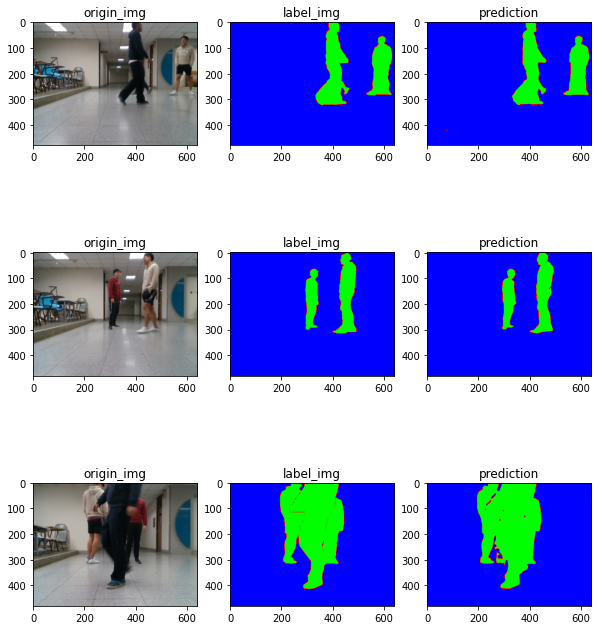

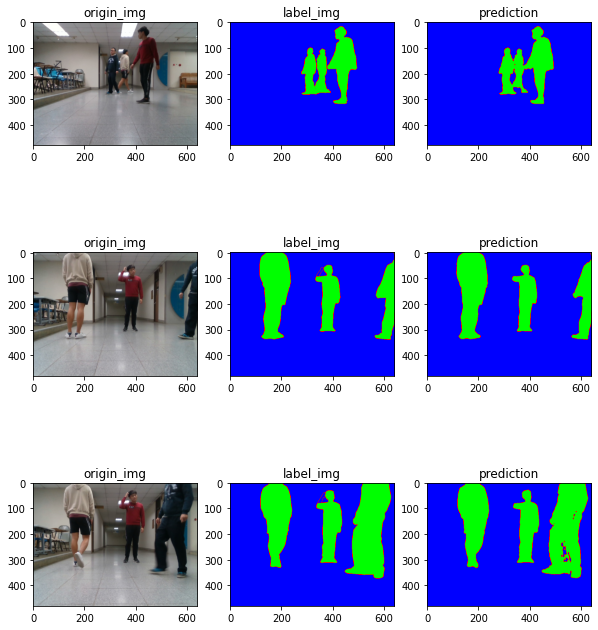

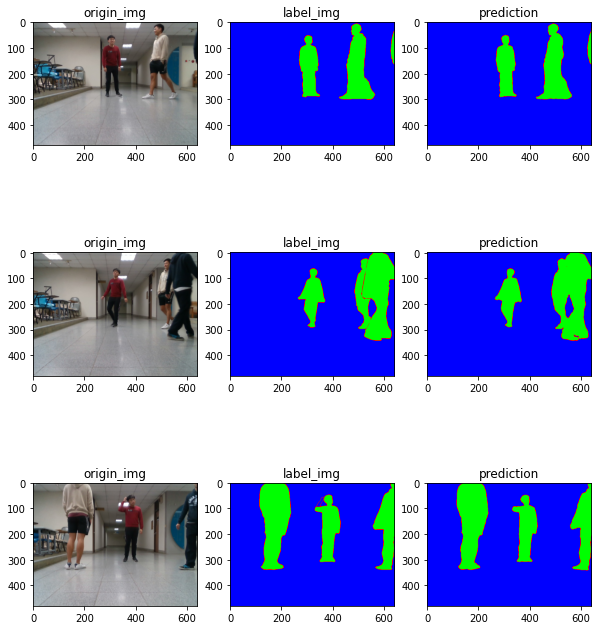

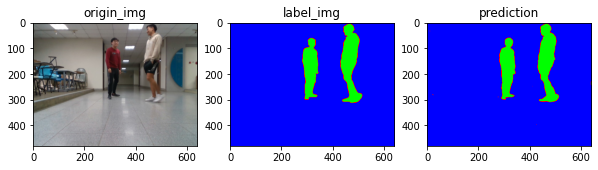

In [18]:
prediction(model, "resnetunet_mobilenet_v2_batch3_epoch450_RMSprop_lr0.0001.pkl")